# Computing contagion models for the supervision of financial networks in Honduras
<br />

### Evelyn Flores
### Fredy Vides 
### Department of Statistics and Research, Comisión Nacional de Bancos y Seguros de Honduras

This notebook is based on the methods presented in the document [1], and contains programs for the computation of discrete-time sequential dynamical models of the form:
$$
\mathbf{x}(k+1)= \mathbf{f}_{\mathbf{u}}(\boldsymbol{\lambda}_{\rho}\odot(\boldsymbol{\rho}\odot(\mathbf{1}_n-\boldsymbol{\delta}\odot\mathbf{x}(k))-\alpha E_{t} \mathbf{x}(k))), k\geq 0
$$
for some given data matrices and parameters $\boldsymbol{\lambda}_{\rho},\boldsymbol{\rho},\boldsymbol{\delta},
\alpha,E_{t}$ corresponding to the state of a financial network $\mathcal{F}_t:=(\mathcal{V}_t,\mathcal{E}_t)$ at a given time $t$ of interest.


# Initial configuration

In [1]:
from pandas import read_csv
from numpy import where,array,zeros,sort,linspace

# Input data

In [2]:
Resources = read_csv('../Data/Resources.csv',header=None).values
BalancesDue = read_csv('../Data/BalancesDue.csv',header=None).values
Thresholds = read_csv('../Data/Thresholds.csv',header=None).values
n = int(41/41*len(Resources))
Resources = Resources[:n,:]
BalancesDue = BalancesDue[:n,:n]
Thresholds = Thresholds[:n,:]
N = n
Institutions = zeros(N)
Institutions = Institutions.astype('str')
for k in range(N):
    Institutions[k] = 'I_'+str(k+1)
Institutions

array(['I_1', 'I_2', 'I_3', 'I_4', 'I_5', 'I_6', 'I_7', 'I_8', 'I_9',
       'I_10', 'I_11', 'I_12', 'I_13', 'I_14', 'I_15', 'I_16', 'I_17',
       'I_18', 'I_19', 'I_20', 'I_21', 'I_22', 'I_23', 'I_24', 'I_25',
       'I_26', 'I_27', 'I_28', 'I_29', 'I_30', 'I_31', 'I_32', 'I_33',
       'I_34', 'I_35', 'I_36', 'I_37', 'I_38', 'I_39', 'I_40', 'I_41'],
      dtype='<U32')

## Definition of sequential dynamical contagion model

In [3]:
def NetworkDynamicsModel(recursos,saldos_adeudados,umbral,mode,n0 = 0,severidad = 1,path_computation = True,next_state = -1,silent_mode = False):
    from numpy import zeros, where, ones, hstack, linspace, sort
    from networkx import DiGraph, draw_networkx, node_connected_component,circular_layout,spectral_layout
    from matplotlib.pyplot import show, subplot
    from time import time
    descuento = (1-.099*recursos[:,1:2]/recursos[:,0:1])
    E = severidad*saldos_adeudados
    D = 1/recursos[:,1:2]
    def f(x):
        return x<umbral
    def T(x):
        return f(D*(recursos[:,0:1]*(1-descuento*x)-E@x)).astype('int')
        
    n = len(recursos)
    TA = []
    NI = []
    
    base = linspace(0,n-1,n)
    base = 2**base
    
    if silent_mode==False:
        print('Computing states set.')
        s0 = time()
    z0 = zeros([n,1])
    z0[:,0] = int2bin(n0,n)
    z1 = z0.copy()
    TA0 = int(base.dot(z1)[0])
    z1 = T(z1)
    TA1 = int(base.dot(z1)[0])
    TA.append(int(TA0))
    TA.append(TA1)
    NI.append(int(sum(z0)[0]))
    NI.append(int(sum(z1)[0]))
    while abs(TA0-TA1)>0:
        TA0 = TA1
        z1 = T(z1)
        TA1 = int(base.dot(z1)[0])
        TA.append(TA1)
        NI.append(int(sum(z1)[0]))
    TA = sort(list(set(TA).intersection(TA)))
    m = len(TA)
    if m == 1:
        St = NI
    elif m > 1:
        St = NI
        NI = hstack((NI[1:],NI[-1]))
        TA = hstack((TA[1:],TA[-1]))
            
    if silent_mode==False:
        print('Elapsed time: ',time()-s0)
    
    if silent_mode:
        G = []
    else:
        print('Computing relational graph.')
        s0 = time()
        nodes = []
        edges = []
        s = []
        t = []
        for j in range(n):
            f0 = where(saldos_adeudados[j,:]>0)[0]+1
            nodes.append(j+1)
            t = hstack((t,f0))
            s = hstack((s,(j+1)*ones(len(f0))))

        s = s.astype('int')
        t = t.astype('int')
        for k in range(len(s)):
            edges.append((s[k],t[k]))

        G = DiGraph()
        G.add_nodes_from(nodes)
        G.add_edges_from(edges)
        print('Elapsed time: ',time()-s0)

        if path_computation:
            print('Computing contagion path.')
            s0 = time()
            nodes = St
            edges = []
            for j in range(m):
                edges.append((St[j],NI[j]))
            TAgraph = DiGraph()
            TAgraph.add_nodes_from(nodes)
            TAgraph.add_edges_from(edges)
            print('Elapsed time: ',time()-s0)
            if next_state > len(TA):
                next_state = -1
            final_state = TA[next_state]
            pos = circular_layout(TAgraph)
            if len(TA)<2:
                color_map = 'red'
            else:
                color_map = ['cyan']
                for k in range(len(TA)-2):
                    color_map.append('darkgreen')
                color_map.append('red')
            subplot(121)
            draw_networkx(TAgraph,pos = pos,node_color = color_map)
    
    
    
            print('Computing initial contagion graph.')
            s0 = time()
            pos = circular_layout(G)
            color_map = state_color_map(G,n0)
            subplot(222)
            draw_networkx(G,pos = pos,node_color = color_map)
            print('Elapsed time: ',time()-s0)
            print('Computing final contagion graph.')
            s0 = time()
            color_map = state_color_map(G,final_state)
            subplot(224)
            draw_networkx(G,pos = pos,node_color = color_map)
            print('Elapsed time: ',time()-s0)
            show()
        else:
            TAgraph = G
    
    return TA,G,NI

def int2bin(x,l):
    from numpy import binary_repr,zeros
    x = binary_repr(x,l)
    n = zeros((l))
    for k in range(l):
        n[k] = int(x[l-k-1])
    return n

def state_color_map(InterBaNet,state):
    n = len(InterBaNet.nodes)
    state = int2bin(state,n)
    
    color_map = []
    
    for x in InterBaNet.nodes:
        if state[x-1] > 0:
            color_map.append('red')
        else:
            color_map.append('limegreen')
    return color_map

# Contagion Simulation

## Initial state setting

In [4]:
List = Institutions[[0]]
state = 0
for x in List:
    state = state + 2**where(Institutions==x)[0][0]
print('States corresponding to:')
print(List)
print(state)
print(int2bin(state,N))

States corresponding to:
['I_1']
1
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## Contagion path computation

Computing contagion path for: 
['I_1']
Computing states set.
Elapsed time:  0.0
Computing relational graph.
Elapsed time:  0.00821995735168457
Computing contagion path.
Elapsed time:  0.0
Computing initial contagion graph.
Elapsed time:  1.3723394870758057
Computing final contagion graph.
Elapsed time:  1.6314923763275146


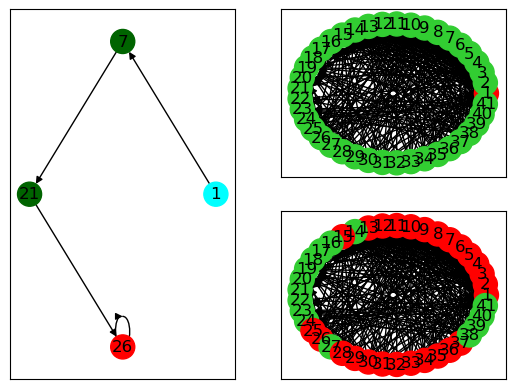

In [5]:
print('Computing contagion path for: ')
print(List)
TA,InterBaNet,NI = NetworkDynamicsModel(Resources,BalancesDue,Thresholds,1,state,severidad = 1,next_state=-1)

## Contagion Indicators

### Contagion indicator $ind_\infty(G,s,t)$

The indicator $ind_\infty(G,s,t)$ is defined by the expression:
$$ind_\infty(G,s,t):=\frac{\mathbf{1}_n^\top\left(\mathbf{x}(N)-\mathbf{x}(0)\right)}{n-\mathbf{1}_n^\top \mathbf{x}(0)}$$
where $G$ denotes a list of institutions in the financial network under consideration, $s$ denotes the severity level, $t$ denotes the time period, and where $N$ is determined by the expression:
$$N:=\min \left\{ k\geq 0 \left| \mathbf{N}(\mathbf{x}(k+1))=\mathbf{N}(\mathbf{x}(k))\right.\right\}$$

### Contagion indicator $ind_{NSI}(I,t)$

The indicator $ind_{NSI}(I,t)$ is defined by the expression:
$$ind_{NSI}(I,t):=\frac{1}{L}\sum_{k=1}^L \delta_{M_{k,\infty}}\left(ind_\infty\left(I,s_k,t\right)\right)$$
where $I$ denotes the institution in the financial network under consideration, $L$ is the number of severity levels, $s_1,\ldots,s_L$ denote the severity levels, $M_{1,\infty},\ldots,M_{L,\infty}$ represent the maximum values attained by $ind_\infty$ for each severity level, $t$ denotes the time period, and where $\delta$ denotes the Kronecker delta determined by the expression:
$$  \delta_{a}(x):=\left\{
\begin{array}{ll}
     1, &  x=a\\
     0, & x\neq a
\end{array}
\right.$$

## Computation of sets of indicators

Computation of sets of indicators for the following list of institutions:

In [6]:
Financial_Institutions = Institutions[:15]

### Sets of $ind_\infty(G,s,t)$ and $ind_{NSI}(I,t)$ indicators

In [7]:
from numpy import linspace
severity = linspace(0,1,5)
severity = severity[1:]

In [8]:
from numpy import linspace,zeros
severity = linspace(0,1,5)
severity = severity[1:]
ls = len(severity)
Ind_1 = zeros((len(Financial_Institutions),ls))
Ind_inf = Ind_1.copy()
Number_of_Rounds = Ind_1.copy()
for k in range(len(severity)):
    ind_1 = []
    ind_inf = []
    RN = []
    for x in Financial_Institutions:
        state = 2**where(Institutions==x)[0][0]
        TA,InterBaNet,NI = NetworkDynamicsModel(Resources,BalancesDue,Thresholds,1,state,severidad = severity[k],silent_mode=True)
        ind_1.append(sum(int2bin(TA[0],N)-int2bin(state,N))/(N-sum(int2bin(state,N))))
        ind_inf.append(sum(int2bin(TA[-1],N)-int2bin(state,N))/(N-sum(int2bin(state,N))))
        RN.append(len(TA)-1)
    Ind_1[:,k] = ind_1
    Ind_inf[:,k] = ind_inf
    Number_of_Rounds[:,k] = RN 
Number_of_Rounds = Number_of_Rounds.astype('int')
from pandas import DataFrame
Ind_inf_df = DataFrame({'Severity: 25%':list(100*Ind_inf[:15,0]),'Severity: 50%':list(100*Ind_inf[:15,1]),'Severity: 75%':list(100*Ind_inf[:15,2]),'Severity: 100%':list(100*Ind_inf[:15,3])},index=Institutions[:15])
T0 = Ind_inf_df.values
nt0 = T0.shape[1]
mt0 = zeros(nt0)
for t in range(nt0):
    mt0[t] = max(T0[:,t])
    
rt0 = T0.shape[0]
Ind_NSI = zeros(rt0)
for j in range(rt0):
    Ind_NSI[j]=sum(T0[j,:]==mt0)/nt0

Ind_NSI_df = DataFrame({'ind_NIS: ':list(100*Ind_NSI)},index=Financial_Institutions)

print('\n\nNetwork contagion percentages for the set of ind_inf indicators: \n')
print(Ind_inf_df)
print('\n\nNetwork systemic importance percentages for the set of ind_NSI indicators: \n')
print(Ind_NSI_df)



Network contagion percentages for the set of ind_inf indicators: 

      Severity: 25%  Severity: 50%  Severity: 75%  Severity: 100%
I_1             2.5           47.5           57.5            62.5
I_2             0.0            0.0           57.5            62.5
I_3             0.0            0.0            0.0             0.0
I_4             0.0            2.5           57.5            62.5
I_5             0.0            0.0            0.0             0.0
I_6             0.0            0.0            0.0             0.0
I_7             0.0           47.5           57.5            62.5
I_8             0.0            0.0            0.0            62.5
I_9             0.0            0.0            0.0             0.0
I_10            0.0            0.0            0.0             0.0
I_11            0.0           47.5           57.5            62.5
I_12            0.0            0.0            0.0             0.0
I_13            0.0            0.0            0.0             2.5
I_14   

## Financial Institutions Classification

In [9]:
severity_level = .75
severity_level = where(severity==severity_level)[0][0]

### Institutions classified by $ind_{NIS}(I,t)$

In [11]:
eps = 1e-1
r_ind_NIS = []
for x in Ind_NSI:
    r_ind_NIS.append(round(100*x,1))
scales = sort(list(set(r_ind_NIS)))
class_NSI = []
for j in range(len(scales)):
    class0=[]
    for k in range(len(Financial_Institutions)):
        if abs(100*Ind_NSI[k]-scales[j])<=eps:
            class0.append(Financial_Institutions[k])
    class_NSI.append(class0)
class_NSI = class_NSI[::-1]
l0 = len(class_NSI)
Groups = []
for k in range(l0):
    Groups.append('G_'+str(k+1)+':')
class_NSI_df = DataFrame({'Institutions: ':class_NSI},index=Groups)
class_NSI_df

,Institutions:
G_1:,[I_1]
G_2:,"[I_7, I_11]"
G_3:,"[I_2, I_4]"
G_4:,[I_8]
G_5:,"[I_3, I_5, I_6, I_9, I_10, I_12, I_13, I_14, I..."


## References

1. Flores, E., Vides, F. (2024). Computing contagion models for the supervision of financial networks in Honduras. Technical report. In preparation.